In [1]:
import yfinance as yf
import pandas as pd
import zipfile
import json
from lxml import etree
from io import StringIO
from datetime import date
from tqdm.notebook import tqdm
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
import pickle

In [2]:
# Set directory and device
# set device
device = torch.device(0 if torch.cuda.is_available() else -1)
print('Device:', device)

# set directory for data and model
data_dir = 'dataset/'
model_dir = 'model/'
# create directory for data
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


Device: cuda:0


In [3]:
# List of tickers / companies
companies = ['AAPL','MSFT','AMZN','GOOG','AMD','NVDA','TSLA','YELP','NFLX','ADBE','BA','AIG']

Historical Stock Data

In [ ]:
# fetch historical stock data
company_list = companies
start_date = '2010-01-01'
end_date = '2020-12-31'
filename = data_dir + 'historical_stock_data.csv'

def save_historical_data_to_csv(companies, start_date, end_date, filename):
    data = pd.DataFrame()

    for company in companies:
        print(f'Retrieving data for {company}...')
        stock_data = yf.download(company, start=start_date, end=end_date)
        if not stock_data.empty:
            stock_data['Company'] = company
            data = pd.concat([data, stock_data]) 
        else:
            print(f'No data available for {company}.')
        print()

    if not data.empty:
        data.to_csv(filename)
        print(f'Historical stock data saved to {filename}.')
    else:
        print('No data available for any company.')

save_historical_data_to_csv(company_list, start_date, end_date, filename)

In [4]:
# load stock data from csv file instead of fetching from Yahoo Finance
path = data_dir + 'historical_stock_data.csv'
stock_data = pd.read_csv(path, index_col=0, parse_dates=True)
display(stock_data.head(5))
df_stock = stock_data.copy()
df_stock = df_stock.reset_index()

,Open,High,Low,Close,Adj Close,Volume,Company
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.496296,493729600,AAPL
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.507525,601904800,AAPL
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.404015,552160000,AAPL
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.392177,477131200,AAPL
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.434674,447610800,AAPL


In [ ]:
# plot historical stock data
plt.figure(figsize=(15, 10))
sns.lineplot(data=df_stock, x='Date', y='Close', hue='Company')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [5]:
# calculate daily returns for each company using pct_change() of closing price
stock_data['daily_return'] = stock_data.groupby('Company')['Close'].pct_change()
display(stock_data[stock_data['Company'] == 'MSFT'].head(5))
df_stock = stock_data.copy()
df_stock = df_stock.reset_index()

,Open,High,Low,Close,Adj Close,Volume,Company,daily_return
Date,,,,,,,,
2010-01-04,30.620001,31.100000,30.590000,30.950001,23.572374,38409100,MSFT,NaN
2010-01-05,30.850000,31.100000,30.639999,30.959999,23.579987,49749600,MSFT,0.000323
2010-01-06,30.879999,31.080000,30.520000,30.770000,23.435276,58182400,MSFT,-0.006137
2010-01-07,30.629999,30.700001,30.190001,30.450001,23.191555,50559700,MSFT,-0.010400
2010-01-08,30.280001,30.879999,30.240000,30.660000,23.351490,51197400,MSFT,0.006897


In [ ]:
# plot daily returns 
plt.figure(figsize=(15, 10))
sns.lineplot(data=df_stock, x='Date', y='daily_return', hue='Company')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

Fetching News Headlines and Sentiment Analysis

In [ ]:
# fetch news headlines from https://www.kaggle.com/code/shtrausslearning/news-sentiment-based-trading-strategy/notebook (this script loads the dataset from a local directory - ./dataset/headlines_archive)
data_df_news = []
data = None 
ret = []
ret_f = []

# helper function performs the jsn parsing 
def jsonParser(json_data): 
    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
        
    return main_tickers, final_headlines


with zipfile.ZipFile("./dataset/headlines_archive", "r") as z:
    
    for filename in tqdm(z.namelist()): 
#         print(filename)
        try:               
            #print('Running {}'.format(filename))
            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                
                #Step 1: Parse the News Jsons 
                main_tickers, final_headlines = jsonParser(json_data) 
                
                if len(final_headlines) != json_data['count']:
                    continue
                    
                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
                
               #Step 3: Merge all the data in a data frame
                df_dict = {'company': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)}
                
                df_f = pd.DataFrame(df_dict)                    
                data_df_news.append(df_f)
                
        except:
            pass  


# merge all dataframes
data_df_news=pd.concat(data_df_news)
# data_df_news = data_df_news[~(data_df_news['company'] == '')] # remove empty company names
data_df_news = data_df_news[data_df_news['company'] != ''] # remove empty company names
print("total news headlines: ", data_df_news.shape)
data_df_news = data_df_news[data_df_news['company'].isin(companies)] # select only companies in our list
data_df_news = data_df_news[data_df_news["headline"] != ""] # remove empty headlines
print("with only selected companies: ",data_df_news.shape)
display(data_df_news.head(5))


In [ ]:
# sentiment analysis on news headlines
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-financial-news-sentiment-en")
sa_roberta = pipeline("sentiment-analysis", model="soleimanian/financial-roberta-large-sentiment", device=device)

batch_size = 64
sentiments = []

for i in range(0, len(data_df_news), batch_size):
    batch = data_df_news['headline'].iloc[i:i+batch_size].tolist()
    results = sa_roberta(batch)
    sentiments.extend([result['label'] for result in results])

data_df_news['sentiment'] = sentiments
display(data_df_news.head(5))
save_dir = data_dir + 'news_headlines_sentiment.csv'
data_df_news.to_csv(save_dir)

In [7]:
# laod news headlines with sentiment from previuously saved csv file
path = data_dir + 'news_headlines_sentiment.csv'
data_df_news = pd.read_csv(path, index_col=0, parse_dates=True)
display(data_df_news.head(5))
df = data_df_news.copy()
df['date'] = pd.to_datetime(df['date'])
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
# original sentiment labels
print(le.classes_)

,company,headline,date,sentiment
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,negative
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,positive
3,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,neutral
6,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,positive
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,negative


['negative' 'neutral' 'positive']


In [ ]:
# plot sentiment distribution for each company
for company in companies:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df[df['company'] == company], x='date', y='sentiment')
    plt.title(f'Sentiment Analysis Over Time for {company}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.show()

Merge Stock Data and News Headlines

In [24]:
# merge stock data and news headlines
df_merged = pd.merge(df_stock, df, left_on=['Company', 'Date'], right_on=['company', 'date'], how='inner')
df_merged = df_merged.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Company', 'headline', 'date', 'Volume'])
df_merged = df_merged.set_index('Date') # set date as index

display(df_merged.head(5))
print(df_merged.shape)

,daily_return,company,sentiment
Date,,,
2011-06-07,-0.017749,AAPL,0
2011-06-14,0.017881,AAPL,2
2011-06-20,-0.015425,AAPL,0
2011-07-07,0.015465,AAPL,2
2011-07-13,0.012071,AAPL,2


(3401, 3)


In [ ]:
# to train model on all companies, use one-hot encoded dataset

# one-hot encode company names
df_merged = pd.get_dummies(df_merged, columns=['company'])

# move daily return to the last column
temp = df_merged.pop('daily_return')
df_merged['daily_return'] = temp

df_merged = df_merged.sort_index() # sort by date
df_merged = df_merged.dropna() # drop rows with NaN values

display(df_merged.head(5))
print(df_merged.shape)

In [25]:
# for training model on specific company, use this code

# data for specific company
# company_name = 'AAPL'
company_name = 'MSFT'
df_merged = df_merged[df_merged["company"] == company_name]

# move daily return to the last column
temp = df_merged.pop('daily_return')
df_merged['daily_return'] = temp

df_merged = df_merged.sort_index() # sort by date
df_merged = df_merged.dropna() # drop rows with NaN values
df_merged = df_merged.drop(columns = ["company"])

display(df_merged.head(5))
print(df_merged.shape)

,sentiment,daily_return
Date,,
2011-05-10,1,-0.006194
2011-05-10,2,-0.006194
2011-05-19,0,0.001215
2011-05-19,2,0.001215
2011-05-19,1,0.001215


(294, 2)


Model and Dataset Class

In [10]:
# dataset class
class StockPriceDataset(Dataset):
    def __init__(self, data, window_size, output_dim):
        self.window_size = window_size
        self.data = data
        self.output_dim = output_dim
        self.normalize()

    def normalize(self):
        self.data["daily_return"] = (self.data["daily_return"] - self.data["daily_return"].mean()) / self.data["daily_return"].std()

    def __len__(self):
        return len(self.data) - self.window_size + 1 - self.output_dim

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window_size -1].values # sequence of window_size - 1 days
        y = self.data.iloc[idx + self.window_size -1 : idx + self.window_size -1 + self.output_dim, -1:].values # next output_dim days
        return torch.tensor(x).float().to(device), torch.tensor(y).float().to(device)

In [11]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden_n, _) = self.lstm(x)
        
        out = self.fc(hidden_n[-1, :, :])

        return out 

In [ ]:
# GRU model class
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, hidden_n = self.gru(x)
        out = self.fc(hidden_n[-1, :, :])
        return out 


Create Dataset and DataLoader, Set Hyperparameters and Build Model

In [26]:
# Hyperparameters
window_size = 20  # sequence length for each input of time series data
input_dim = df_merged.shape[1] # number of features
hidden_dim = 100 # number of hidden units
num_layers = 3 # number of LSTM / GRU layers
output_dim = 10 # predict next specified days 
num_epochs = 5
batch_size = 1
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
# create dataset and dataloader

# train, validation, test split
temp = df_merged.iloc[:int(0.8*len(df_merged))]
train = temp.iloc[:int(0.8*len(temp))]
val = temp.iloc[int(0.8*len(temp)):]
test = df_merged.iloc[int(0.8*len(df_merged)):]

# create dataset
train = StockPriceDataset(train, window_size, output_dim)
val = StockPriceDataset(val, window_size, output_dim)
test = StockPriceDataset(test, window_size, output_dim)

# create dataloader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

C:\Users\fahim\AppData\Local\Temp\ipykernel_19816\1250246073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["daily_return"] = (self.data["daily_return"] - self.data["daily_return"].mean()) / self.data["daily_return"].std()


In [28]:
# initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


Train Model

In [15]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # plt.savefig("./dump/losses.png")
    # plt.close()

Epoch: 1 	Training Loss: 1.056873 	Validation Loss: 0.516789
Epoch: 2 	Training Loss: 1.046265 	Validation Loss: 0.479854
Epoch: 3 	Training Loss: 1.050533 	Validation Loss: 0.477626
Epoch: 4 	Training Loss: 1.048913 	Validation Loss: 0.478879
Epoch: 5 	Training Loss: 1.047135 	Validation Loss: 0.479849


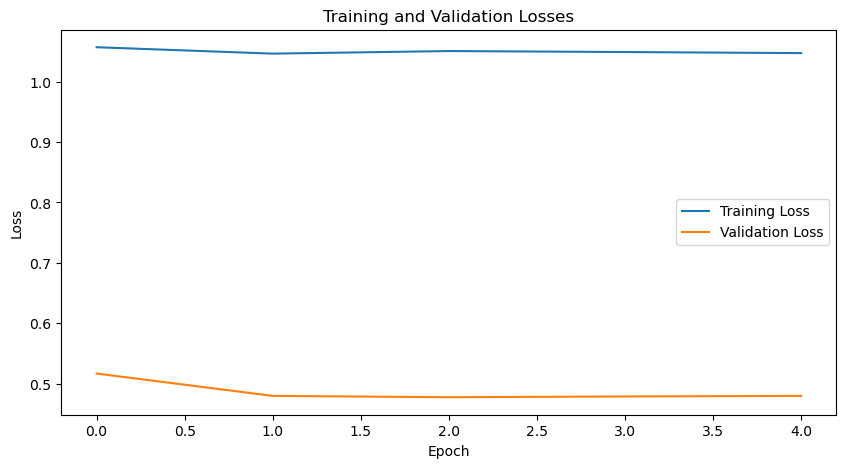

In [29]:
# training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    num_train_batches = 0
    num_val_batches = 0

    # train model
    model.train()
    for sequence in train_loader:
        inputs, targets = sequence
        targets = targets.squeeze(-1) # remove last dimension

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_train_batches += 1
    
    # validate model
    model.eval()
    with torch.no_grad():
        for sequence in val_loader:
            inputs, targets = sequence
            targets = targets.squeeze(-1) # remove last dimension

            output = model(inputs)
            loss = criterion(output, targets)
            
            val_loss += loss.item()
            num_val_batches += 1
    
    train_loss /= num_train_batches
    val_loss /= num_val_batches
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))
plot_losses(train_losses, val_losses)

In [30]:
# Save the trained model
model_name = 'lstm-'
# company_name = 'apple-'
company_name = 'microsoft-'
predoction_days = '10-'
path = model_dir + model_name + company_name + predoction_days + '.pth'
torch.save(model.state_dict(), path)


In [31]:
# save dataset in pickle file
# test_dataset_name = 'test_dataset.pkl'
test_dataset_name = 'test_dataset-'
# company_name = 'apple-'
company_name = 'microsoft-'
predoction_days = '10-'
path = data_dir + test_dataset_name + company_name + predoction_days + '.pkl'
with open(path, 'wb') as f:
    pickle.dump(test, f)